#Load Dataset

In [11]:
import pandas as pd

In [12]:
df = pd.read_csv('tripadvisor_hotel_reviews.csv',encoding='utf-8')

In [13]:
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


#Text Preprocess

In [14]:
def rating(score):
    if score > 3:
        return "Good"
    elif score == 3:
        return "Netral"
    else:
        return "Bad"

In [15]:
df['Rating'] = df['Rating'].apply(rating)

In [16]:
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,Good
1,ok nothing special charge diamond member hilto...,Bad
2,nice rooms not 4* experience hotel monaco seat...,Netral
3,"unique, great stay, wonderful time hotel monac...",Good
4,"great stay great stay, went seahawk game aweso...",Good


In [17]:
df.groupby('Rating').describe()

Review                                                               
        count unique                                                top freq
Rating                                                                      
Bad      3214   3214  ok nothing special charge diamond member hilto...    1
Good    15093  15093  nice hotel expensive parking got good deal sta...    1
Netral   2184   2184  nice rooms not 4* experience hotel monaco seat...    1

In [18]:
review = df['Review'].values

#label = df_temp[['Bad', 'Good', 'Netral']].values

In [19]:
import re
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

stop_words = set(stopwords.words("english")) 
lemmatizer = WordNetLemmatizer()


def clean_text(text):
    text = re.sub(r'[^\w\s]','',text, re.UNICODE)
    text = text.lower()
    text = [lemmatizer.lemmatize(token) for token in text.split(" ")]
    text = [lemmatizer.lemmatize(token, "v") for token in text]
    text = [word for word in text if not word in stop_words]
    text = " ".join(text)
    return text

df['Processed_Reviews'] = df.Review.apply(lambda x: clean_text(x))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [20]:
df.head()

,Review,Rating,Processed_Reviews
0,nice hotel expensive parking got good deal sta...,Good,nice hotel expensive park get good deal stay h...
1,ok nothing special charge diamond member hilto...,Bad,ok nothing special charge diamond member hilto...
2,nice rooms not 4* experience hotel monaco seat...,Netral,nice room 4 experience hotel monaco seattle go...
3,"unique, great stay, wonderful time hotel monac...",Good,unique great stay wonderful time hotel monaco ...
4,"great stay great stay, went seahawk game aweso...",Good,great stay great stay go seahawk game awesome ...


In [21]:
review = df['Processed_Reviews'].values

label = df['Rating'].values

In [22]:
from sklearn.model_selection import train_test_split

review_train, review_test, label_train, label_test = train_test_split(review,label,test_size=0.2)
label_test

array(['Good', 'Good', 'Netral', ..., 'Good', 'Netral', 'Good'],
      dtype=object)

In [23]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [24]:
from sklearn.preprocessing import LabelBinarizer

num = 30000
tokenizer = Tokenizer(num_words=num,oov_token='OOV')

tokenizer.fit_on_texts(review_train)
#tokenizer.fit_on_texts(review_test)

sequences_train = tokenizer.texts_to_sequences(review_train)
sequences_test = tokenizer.texts_to_sequences(review_test)

maxlen=500

padded_train = pad_sequences(sequences_train,maxlen=maxlen, padding = 'post')
padded_test = pad_sequences(sequences_test,maxlen=maxlen, padding = 'post')


In [25]:
lb = LabelBinarizer()
labeled_train = lb.fit_transform(label_train)
labeled_test = lb.transform(label_test)

In [26]:
import pickle

pickle.dump(tokenizer, open('tokenizer.pkl', 'wb'))
pickle.dump(lb, open('label.pkl', 'wb'))

In [27]:
review_train[0]

'lovely hotel great location beautiful stylish hotel staff efficient friendly rooftop bar pool area lovely unfortunately weather fairly overcast stay nt sample pool cocktail civilise way start end even disappointment room overlook central courtyard natural light room limit  '

#Model

In [28]:
!pip install gensim
import numpy as np
import gensim.downloader as api
glove_gensim  = api.load('glove-wiki-gigaword-300') #100 dimension

vec_size = 300
gensim_weight_matrix = np.zeros((num ,vec_size))
gensim_weight_matrix.shape

for word, index in tokenizer.word_index.items():
    if index < num: # since index starts with zero 
        if word in glove_gensim.wv.vocab:
            gensim_weight_matrix[index] = glove_gensim[word]
        else:
            gensim_weight_matrix[index] = np.zeros(300)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
[==================================================] 100.0% 376.1/376.1MB downloaded


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  if sys.path[0] == '':


In [29]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(num,vec_size,input_length=maxlen,weights = [gensim_weight_matrix],trainable = False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200, return_sequences=True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=False)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.001), metrics=['accuracy'])

In [30]:
class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs=None): 
        if(logs.get('accuracy') > 0.85 and logs.get('val_accuracy') > 0.85):
          print("85% validation accuracy reached, stopping training.")
          self.model.stop_training = True

callbacks=myCallback()

#Train

In [31]:
num_epochs = 15
history = model.fit(padded_train,
                    labeled_train,
                    batch_size = 100,
                    epochs=num_epochs,
                    validation_data=(padded_test, labeled_test),
                    verbose=2,
                    callbacks=[callbacks])

Epoch 1/15
164/164 - 68s - loss: 0.5085 - accuracy: 0.8086 - val_loss: 0.4530 - val_accuracy: 0.8387 - 68s/epoch - 413ms/step
Epoch 2/15
164/164 - 52s - loss: 0.4120 - accuracy: 0.8409 - val_loss: 0.4003 - val_accuracy: 0.8485 - 52s/epoch - 314ms/step
Epoch 3/15
164/164 - 51s - loss: 0.4026 - accuracy: 0.8460 - val_loss: 0.3920 - val_accuracy: 0.8509 - 51s/epoch - 311ms/step
Epoch 4/15
85% validation accuracy reached, stopping training.
164/164 - 52s - loss: 0.3505 - accuracy: 0.8652 - val_loss: 0.3849 - val_accuracy: 0.8553 - 52s/epoch - 315ms/step


#Evaluate

In [32]:
import matplotlib.pyplot as plt

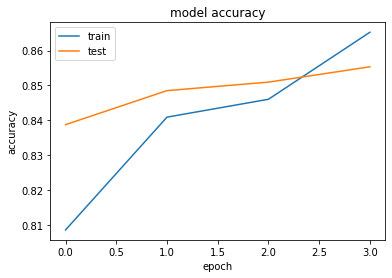

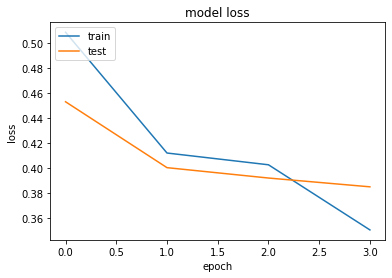

In [33]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [34]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report

In [35]:
label_test[0]

'Good'

In [36]:
pred = model.predict(padded_test)

129/129 [==============================] - 9s 55ms/step


In [37]:
true_labels = np.argmax(labeled_test, axis=-1)
pred_labels = np.argmax(pred, axis=-1)

In [38]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(true_labels, pred_labels))
print(classification_report(true_labels, pred_labels))

[[ 544   54   42]
 [  92 2844   89]
 [ 121  195  118]]
              precision    recall  f1-score   support

           0       0.72      0.85      0.78       640
           1       0.92      0.94      0.93      3025
           2       0.47      0.27      0.35       434

    accuracy                           0.86      4099
   macro avg       0.70      0.69      0.68      4099
weighted avg       0.84      0.86      0.84      4099



In [39]:
model.save('model.h5')

In [40]:
def dl_predict(text):
    clean = clean_text(text)
    seq = tokenizer.texts_to_sequences([clean])
    padded = pad_sequences(seq,maxlen=500, padding='post')

    pred = model.predict(padded)
    # Get the label name back
    result = lb.inverse_transform(pred)[0]
    
    return result

In [41]:
text = ['Nothing Special. Just a regular affordable hotel.',
        'The hotel have pool. The room quite spacious. i love it.',
        'the air conditioner is so broken and the food is disgusting',
        'Such a beautiful Hotel. They got free drinks and good bathtub.',
        'Quite good hotel but this is just ok. the dont have hot water but it worth the price',
        'Boring hotel. The room so smelly i dont recommend this to you']
for texts in text :
  print('Review Prediction {}'.format(dl_predict(texts)))

1/1 [==============================] - 0s 125ms/step
Review Prediction Netral
1/1 [==============================] - 0s 130ms/step
Review Prediction Good
1/1 [==============================] - 0s 123ms/step
Review Prediction Bad
1/1 [==============================] - 0s 130ms/step
Review Prediction Good
1/1 [==============================] - 0s 131ms/step
Review Prediction Netral
1/1 [==============================] - 0s 134ms/step
Review Prediction Bad
